In [18]:
import os
from os.path import join, basename, dirname
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import glob
import multiprocessing
from multiprocessing.pool import Pool
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

%matplotlib inline

In [34]:
TRAIN = '../data/train_images/'
OUT_TRAIN = '../data/train_images_tiles_36_256x256'
os.makedirs(OUT_TRAIN, exist_ok=True)
TRAIN_FILES = glob.glob(os.path.join(TRAIN, '*_1.jpeg'))

In [35]:
def tile(img, sz, N):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    img = np.pad(img, [[pad0 // 2,pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], \
                      [0,0]], constant_values=255)
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'idx':idxs[i]})
    return result

Text(0.5, 1.0, 'tiled image')

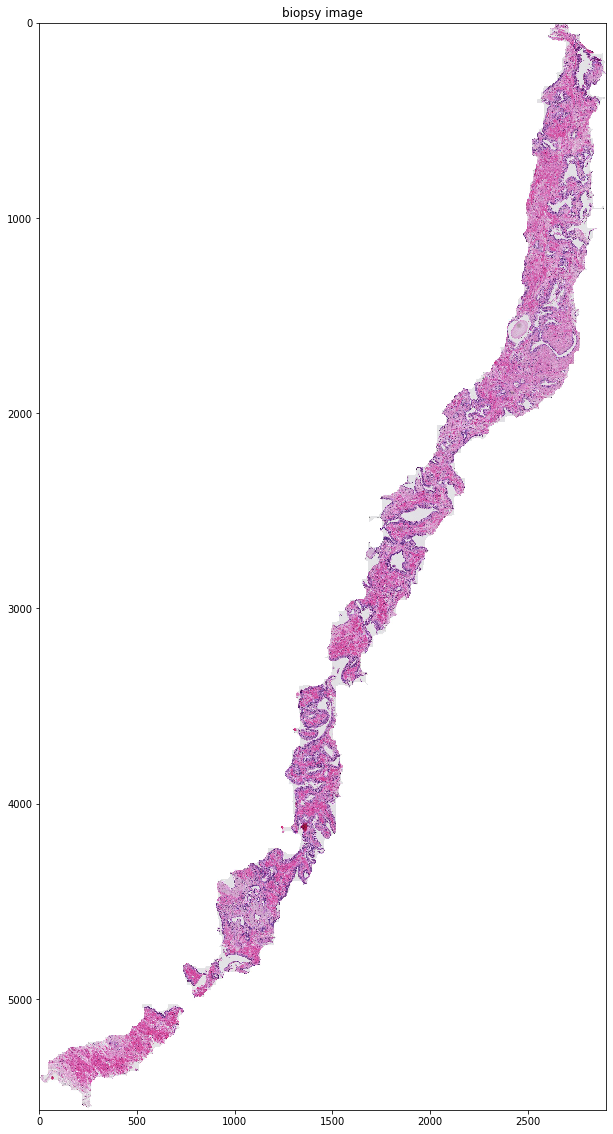

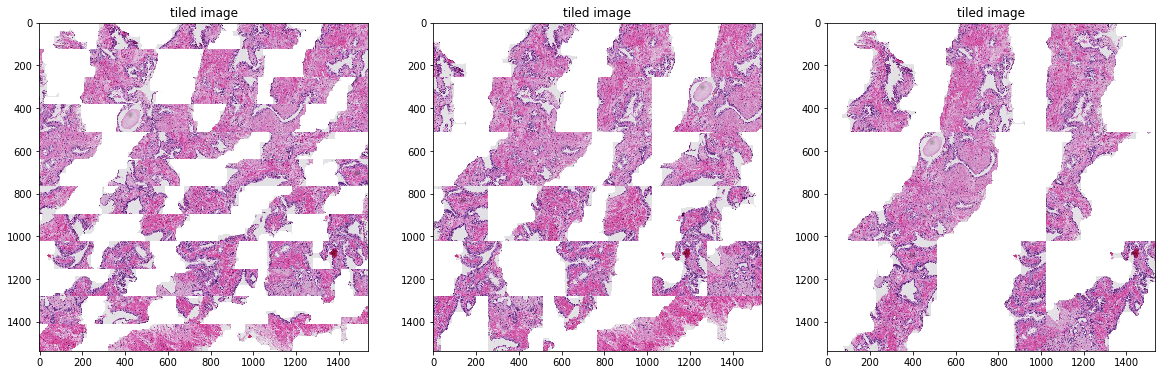

In [40]:
# visualising the masks generated
np.random.seed(5)
sample = np.random.choice(TRAIN_FILES)
img = skimage.io.imread(sample)

fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(img)
ax.set_title('biopsy image')

fig, ax = plt.subplots(1,3,figsize=(20,20))

sz = 128
N = 144

tiles = tile(img, sz, N)
tiles = sorted(tiles, key=lambda x: x['idx']) 
tiles = [t['img'] for t in tiles]

n_rows = int(np.sqrt(N))
tiled_image = []
for i in range(n_rows):
    tiled_image.append(np.concatenate(tiles[n_rows*i:n_rows*i + n_rows], axis=1))
tiled_image = np.concatenate(tiled_image, axis=0)
tiled_image = Image.fromarray(tiled_image)

ax[0].imshow(tiled_image)
ax[0].set_title('tiled image')


sz = 256
N = 36

tiles = tile(img, sz, N)
tiles = sorted(tiles, key=lambda x: x['idx']) 
tiles = [t['img'] for t in tiles]

n_rows = int(np.sqrt(N))
tiled_image = []
for i in range(n_rows):
    tiled_image.append(np.concatenate(tiles[n_rows*i:n_rows*i + n_rows], axis=1))
tiled_image = np.concatenate(tiled_image, axis=0)
tiled_image = Image.fromarray(tiled_image)

ax[1].imshow(tiled_image)
ax[1].set_title('tiled image')

sz = 512
N = 9

tiles = tile(img, sz, N)
tiles = sorted(tiles, key=lambda x: x['idx']) 
tiles = [t['img'] for t in tiles]

n_rows = int(np.sqrt(N))
tiled_image = []
for i in range(n_rows):
    tiled_image.append(np.concatenate(tiles[n_rows*i:n_rows*i + n_rows], axis=1))
tiled_image = np.concatenate(tiled_image, axis=0)
tiled_image = Image.fromarray(tiled_image)

ax[2].imshow(tiled_image)
ax[2].set_title('tiled image')

In [38]:
def process_and_save_image(img_path):
    full_image = skimage.io.imread(img_path)
    tiles = tile(full_image)
    for t in tiles:
        img, idx = t['img'], t['idx']
        save_path = join(OUT_TRAIN, basename(img_path[:-7]) + '_' + str(idx) + '.jpeg')
        skimage.io.imsave(save_path, img, check_contrast=False)

In [39]:
with Pool(multiprocessing.cpu_count()) as pool:
    pool.map(process_and_save_image, TRAIN_FILES)